# Faizaan Ali | HW4 | Tasks 2 & 3

## Task 2

In [1]:
!pip install ucimlrepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from ucimlrepo import fetch_ucirepo

# Fetch dataset (ID = 235) https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption
dataset = fetch_ucirepo(id=235)

# Features and targets
X = dataset.data.features
y = dataset.data.targets

# Combine into a single dataframe, format date
df = pd.concat([X, y], axis=1)
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert all power-related columns to numeric
for col in df.columns:
    if col not in ['Date', 'Time', 'datetime']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna() # drop NaNs

# Keep datetime + all numeric features
feature_cols = [
    'Global_active_power',
    'Global_reactive_power',
    'Voltage',
    'Global_intensity',
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3'
]

df = df[['datetime'] + feature_cols]

# Downsample to hourly averages (massive speedup)
df = df.set_index('datetime')
df = df.resample('H').mean()
df = df.dropna()
df = df.reset_index()

df.head()


/usr/local/lib/python3.12/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)
/tmp/ipython-input-1591083044.py:23: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
/tmp/ipython-input-1591083044.py:46: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean()


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


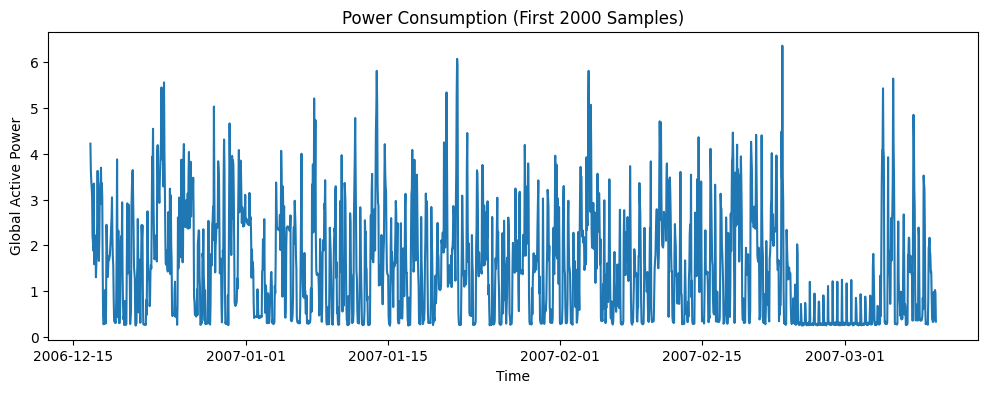

In [2]:
plt.figure(figsize=(12,4))
plt.plot(df['datetime'][:2000], df['Global_active_power'][:2000])
plt.title("Power Consumption (First 2000 Samples)")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.show()


Just plotting Global_Active_Power against time here. We can see how volatile the series is, with some very high spikes and dips. In terms of length of data, it ranges from 2006-2008 which give us a lot of hourly timesteps to work with.

We need sequence models for the Global Power Consumption dataset because electricity usage is inherently time-dependent. This is because current power consumption depends on recent historical patterns such as daily cycles, weekly trends, seasonality, and other short-term fluctuations. A standard feed-forward network treats inputs as independent features and cannot naturally model temporal order or dependencies across time. Sequence models like RNNs (or LSTMs/GRUs) maintain a hidden state that evolves over timesteps, allowing them to learn patterns such as lag effects, temporal autocorrelation, and long-term trends. Since the target value depends on how the signal evolved over time, not just the most recent snapshot, sequence models are better suited for capturing the structure of this dataset.

In [3]:
# split data first (chronologically)
raw_data = df[feature_cols].values

train_size_raw = int(0.7 * len(raw_data))
val_size_raw = int(0.15 * len(raw_data))

train_raw = raw_data[:train_size_raw]
val_raw = raw_data[train_size_raw:train_size_raw + val_size_raw]
test_raw = raw_data[train_size_raw + val_size_raw:]

# Fit scaler only on training data (avoid leaks)
scaler = MinMaxScaler()
scaler.fit(train_raw)

train_scaled = scaler.transform(train_raw)
val_scaled = scaler.transform(val_raw)
test_scaled = scaler.transform(test_raw)

# create seqs for training
sequence_length = 168  # 7 days * 24 hrs

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # predict Global_active_power
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, sequence_length)
X_val, y_val = create_sequences(val_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)


In [4]:
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(10000).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)


### Part 1: Simple RNN

This model uses a single-layer SimpleRNN with 50 hidden units. At each time step, the RNN processes the input feature vector and updates its hidden state using a tanh activation function, which allows the hidden values to remain bounded between -1 and 1 while modeling nonlinear temporal relationships. The final hidden state is passed to a fully connected Dense layer with a linear activation, which produces a single continuous output for regression. The model is trained using the Adam optimizer with mean squared error (MSE) loss for predicting a continuous target value.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,951 (11.53 KB)

 Trainable params: 2,951 (11.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0311 - mse: 0.0311 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 2/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 3/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 4/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0092 - mse: 0.0092 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 5/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0080 - val_mse: 0.0080


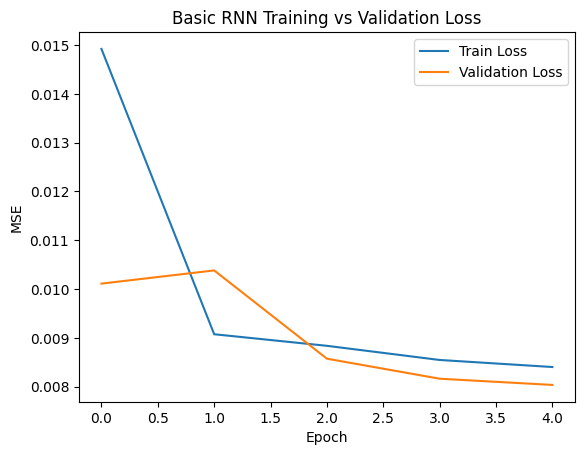

Validation RMSE: 0.0897
Test RMSE: 0.0779


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# simple RNN
model = Sequential([
    SimpleRNN(
        units=50,
        activation='tanh',              # Hidden state activation at each timestep
        input_shape=(sequence_length, len(feature_cols))
    ),
    Dense(1, activation='linear')       # Output layer (regression)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

model.summary()

# training
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[early_stop]
)

# plot loss train and val
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.title("Basic RNN Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

# RMSE
val_mse = model.evaluate(val_dataset, verbose=0)
test_mse = model.evaluate(test_dataset, verbose=0)

val_rmse = np.sqrt(val_mse[0])
test_rmse = np.sqrt(test_mse[0])

print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


### Part 2: LSTM + GRU

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

# LSTM Initialization
lstm_model = Sequential([
    LSTM(
        units=50,
        activation='tanh',          # hidden state activation
        input_shape=(sequence_length, len(feature_cols))
    ),
    Dense(1, activation='linear')   # regression output
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mse'])


# GRU Initialization
gru_model = Sequential([
    GRU(
        units=50,
        activation='tanh',          # hidden state activation
        input_shape=(sequence_length, len(feature_cols))
    ),
    Dense(1, activation='linear')   # regression
])

gru_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

print("LSTM Summary:")
lstm_model.summary()

print("\nGRU Summary:")
gru_model.summary()


LSTM Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,651 (45.51 KB)

 Trainable params: 11,651 (45.51 KB)

 Non-trainable params: 0 (0.00 B)


GRU Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         8,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,901 (34.77 KB)

 Trainable params: 8,901 (34.77 KB)

 Non-trainable params: 0 (0.00 B)


LSTM Training
Epoch 1/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 2/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 3/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 4/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 5/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0076 - val_mse: 0.0076

GRU Training
Epoch 1/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 2/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 3/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 4/5
372/372 ━━━━━━━━━━━

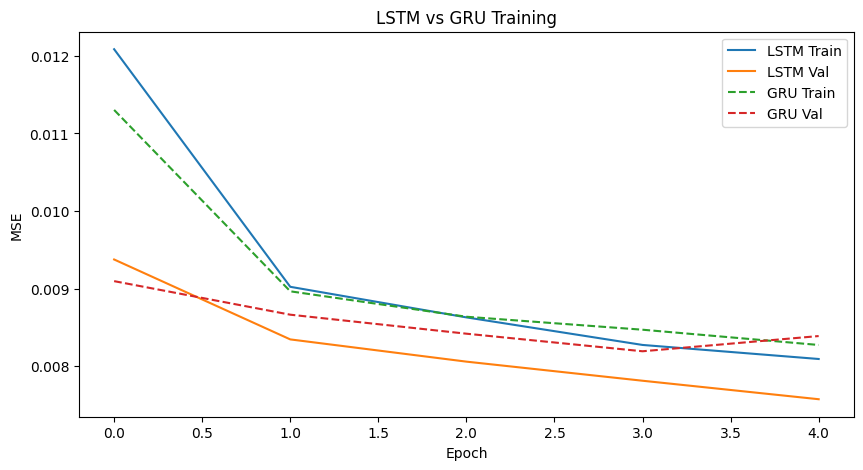

LSTM Validation RMSE: 0.087
LSTM Test RMSE: 0.0757

GRU Validation RMSE: 0.0905
GRU Test RMSE: 0.0789


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=3, restore_best_weights=True)

# LSTM training
print("\nLSTM Training")
lstm_history = lstm_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[early_stop],
    verbose=1
)

# GRU training
print("\nGRU Training")
gru_history = gru_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[early_stop],
    verbose=1
)

# plot losses
plt.figure(figsize=(10,5))

plt.plot(lstm_history.history['loss'], label="LSTM Train")
plt.plot(lstm_history.history['val_loss'], label="LSTM Val")

plt.plot(gru_history.history['loss'], linestyle='--', label="GRU Train")
plt.plot(gru_history.history['val_loss'], linestyle='--', label="GRU Val")

plt.legend()
plt.title("LSTM vs GRU Training")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

# RMSE
lstm_val_rmse = np.sqrt(lstm_model.evaluate(val_dataset, verbose=0)[0])
lstm_test_rmse = np.sqrt(lstm_model.evaluate(test_dataset, verbose=0)[0])

gru_val_rmse = np.sqrt(gru_model.evaluate(val_dataset, verbose=0)[0])
gru_test_rmse = np.sqrt(gru_model.evaluate(test_dataset, verbose=0)[0])

print("LSTM Validation RMSE:", round(lstm_val_rmse, 4))
print("LSTM Test RMSE:", round(lstm_test_rmse, 4))

print("\nGRU Validation RMSE:", round(gru_val_rmse, 4))
print("GRU Test RMSE:", round(gru_test_rmse, 4))


The three models differ primarily in how they handle temporal memory. The SimpleRNN updates its hidden state using a single recurrent transformation with a tanh activation at each time step. While simple and computationally efficient, it suffers from vanishing gradients, meaning it struggles to retain information from earlier time steps when sequences become longer or more complex. The GRU improves on this by introducing gating mechanisms (update and reset gates) that control how much past information is retained or forgotten, helping stabilize training and capture longer dependencies with fewer parameters than LSTM. The LSTM extends this idea further by using three gates (input, forget, and output) along with a dedicated cell state that explicitly carries long-term information across time steps. This structured memory pathway allows LSTMs to better preserve and selectively update important temporal features. In this  power consumption task where multiple signals evolve over time, the LSTM performs best. This is because its gated cell state more effectively models long-term dependencies and complex feature interactions, which explains its lower validation and test RMSE compared to both the basic RNN and GRU.

### Part 3: Tranformation for feed-forward NN

A traditional feed-forward neural network (FFNN) can be used to solve this problem, but it is not naturally suited for it unless we first transform the time series into fixed input features.

Time-series data can be converted into standard features using a sliding window approach. For example, instead of feeding a sequence step-by-step as an RNN does, we can take the previous 60 time steps and “flatten” them into a single feature vector. If we have 7 variables and a sequence length of 60, the input becomes a vector of size 60*7=420. This vector can then be fed into a standard FFNN with fully connected layers to predict the next time step.

However, while this works, there are limitations. A FFNN does not maintain an internal memory state and does not model temporal dependencies. It treats all past time steps as independent input features rather than sequentially related observations. Also, as the window size increases, the input dimensionality grows quickly, making the model way less efficient and harder to train. In contrast, RNNs, LSTMs, and GRUs are specifically designed to process sequences by sharing parameters across time steps and maintaining hidden states that capture temporal structure more efficiently.

So, although a feed-forward network can solve the problem after converting the time series into lagged features, sequence models are generally better suited because they are designed to model temporal dependencies directly and more effectively.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │       150,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,977 (621.00 KB)

 Trainable params: 158,977 (621.00 KB)

 Non-trainable params: 0 (0.00 B)

FFNN Training
Epoch 1/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0213 - mse: 0.0213 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 2/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 3/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 4/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 5/5
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0086 - val_mse: 0.0086


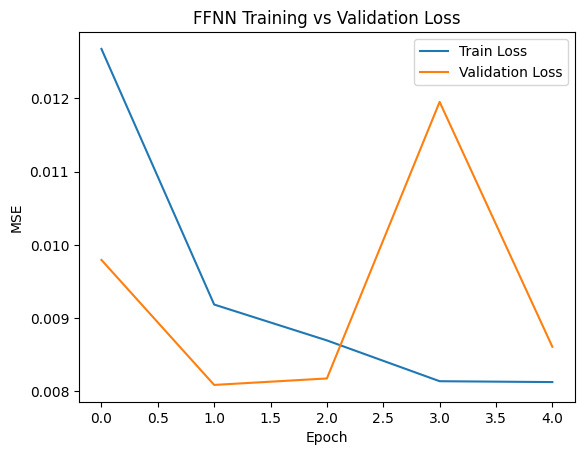

Validation RMSE: 0.0899
Test RMSE: 0.0784


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# flatten datasets
def dataset_to_numpy(dataset):
    X_list, y_list = [], []
    for xb, yb in dataset:
        X_list.append(xb.numpy())
        y_list.append(yb.numpy())
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

X_train, y_train = dataset_to_numpy(train_dataset)
X_val, y_val = dataset_to_numpy(val_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

# Flatten time dimension:
# (samples, seq_len, features) -> (samples, seq_len*features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat   = X_val.reshape(X_val.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

# define FFNN
ffnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_flat.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='linear') # regression
])

ffnn.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

ffnn.summary()

# training
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

print("FFNN Training")
history = ffnn.fit(
    X_train_flat, y_train,
    validation_data=(X_val_flat, y_val),
    epochs=5,
    callbacks=[early_stop],
    verbose=1
)

# plot losses
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.title("FFNN Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

# RMSE
val_mse = ffnn.evaluate(X_val_flat, y_val, verbose=0)
test_mse = ffnn.evaluate(X_test_flat, y_test, verbose=0)

val_rmse = np.sqrt(val_mse[0])
test_rmse = np.sqrt(test_mse[0])

print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


## Task 3

### Part 1: Word Embeddings

In [9]:
# Install
!pip install gensim matplotlib seaborn scikit-learn

import gensim.downloader as api
import numpy as np

# Load pretrained GloVe (100d)
model = api.load("glove-wiki-gigaword-100")

print("Embedding dimension:", model.vector_size)
print("Vocabulary size:", len(model))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 102.9 MB/s eta 0:00:00
[==================================================] 100.0% 128.1/128.1MB downloaded
Embedding dimension: 100
Vocabulary size: 400000


Why GloVe?
https://blog.nastaran.ai/p/understanding-word-embeddings-glove-vs-bert

- Efficient and lightweight compared to BERT
- Captures global co-occurrence statistics (better semantic structure than Word2Vec skip-gram alone)
- Faster for similarity tasks and doesn't use too much memory
- BERT provides contextual embeddings but is heavier and overkill for static word comparison tasks
- However, GloVe cannot naturally handle OOV words easily unlike FastText (no breaking of words into n grams)

In [10]:
import difflib

def get_embedding(word):
    if word in model:
        return model[word]
    else:
        print(f"'{word}' is OOV.")

        # Find closest known word via diff string similarity
        closest = difflib.get_close_matches(word, model.key_to_index.keys(), n=1)

        if closest:
            print("Using closest match:", closest[0])
            return model[closest[0]]

        # fallback: random small vector
        print("Returning random small vector approximation.")
        return np.random.normal(scale=0.01, size=model.vector_size)


w1 = input("Enter first word: ").lower()
w2 = input("Enter second word: ").lower()

vec1 = get_embedding(w1)
vec2 = get_embedding(w2)

print(f"\nEmbedding for {w1}:\n", vec1[:10] if vec1 is not None else None)
print(f"\nEmbedding for {w2}:\n", vec2[:10] if vec2 is not None else None)


Enter first word: Cat
Enter second word: Updation
'updation' is OOV.
Using closest match: updating

Embedding for cat:
 [ 0.23088   0.28283   0.6318   -0.59411  -0.58599   0.63255   0.24402
 -0.14108   0.060815 -0.7898  ]

Embedding for updation:
 [-0.63828  -0.10633   0.63068   0.49024   0.12774   0.37407  -0.34377
  0.049221  0.34509   0.68783 ]


Here, we use the difflib library to handle OOV cases. The get_embedding function will find the top closest match in the embeddings dictionary and return that word in place of the user input.

### Part 2: Cosine Similarity

In [11]:
from numpy.linalg import norm

def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (norm(v1) * norm(v2))

def batch_similarity(pairs):
    results = {}
    for w1, w2 in pairs:
        v1, v2 = get_embedding(w1), get_embedding(w2)
        if v1 is not None and v2 is not None:
            results[(w1, w2)] = cosine_similarity(v1, v2)
    return results

pairs = [("doctor","dog"), ("soldier","knight"), ("truck","van")]
print(batch_similarity(pairs))


{('doctor', 'dog'): np.float32(0.45076594), ('soldier', 'knight'): np.float32(0.3329118), ('truck', 'van'): np.float32(0.40703613)}


Cosine similarity measures the angle between two word vectors, which represents their semantic orientation. In word embeddings, each word is mapped to a high-dimensional vector whose direction represents meaning. When two words such as cat and dog appear in similar contexts, their vectors point in nearly the same direction, resulting in a small angle and high cosine similarity. In contrast, unrelated words like cat and car have vectors pointing in very different directions, producing a large angle and low cosine similarity.

Also, cosine similarity is scale-invariant, meaning it ignores the magnitude (length) of the vectors and focuses only on their direction. Vector magnitude can be influenced by factors such as word frequency or training dynamics rather than semantic meaning. By disregarding magnitude, cosine similarity ensures that two semantically similar words remain similar even if their vector lengths differ.

It also works well in high-dimensional embedding spaces, which can range from 100 to 300 dimensions (100 dims for this task). In such spaces, Euclidean distance can become less meaningful due to the curse of dimensionality. Cosine similarity remains stable because it compares orientation instead of distance, making it more reliable for measuring semantic similarity.

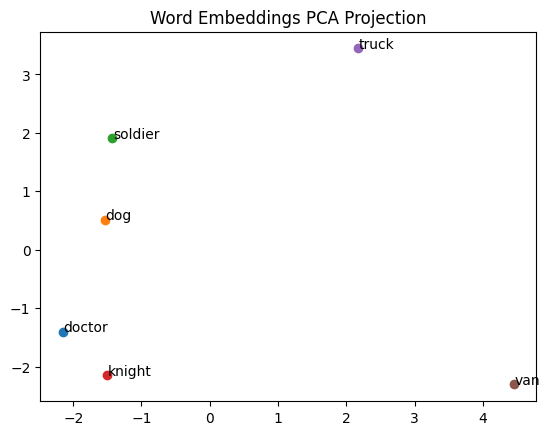

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

words = ["doctor","dog","soldier","knight","truck","van"]
vectors = [get_embedding(w) for w in words]

pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

plt.figure()
for i, word in enumerate(words):
    plt.scatter(reduced[i,0], reduced[i,1])
    plt.text(reduced[i,0]+0.01, reduced[i,1]+0.01, word)

plt.title("Word Embeddings PCA Projection")
plt.show()


### Part 3: Custom Metric (DISSIMILARITY)

In [13]:
from scipy.spatial.distance import euclidean

def compute_metric(v1, v2, metric="cosine"):
    if metric == "cosine":
        # make this dissimilarity now
        return 1 - cosine_similarity(v1, v2)
    elif metric == "euclidean":
        return euclidean(v1, v2)
    elif metric == "contrast":
        cos = cosine_similarity(v1, v2)
        dist = euclidean(v1, v2)
        return dist * (1 - cos)
    else:
        raise ValueError("Invalid metric")

def compare_words(base_word, words, metric="cosine"):
    base_vec = get_embedding(base_word)
    scores = {}
    for w in words:
        vec = get_embedding(w)
        if vec is not None:
            scores[w] = compute_metric(base_vec, vec, metric)
    # sort descending: higher = more dissimilar
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)


Cosine similarity only measures the angle between two vectors, meaning it captures how similar their semantic direction is. However, it ignores how far apart the vectors are in the embedding space. Two words can still have a similar direction (decent cosine score) but still be located far apart in the vector space, meaning they differ in intensity or specificity.

The custom contrast metric combines both angular difference and spatial distance:
Contrast = Euclidean Distance * (1 − Cosine Similarity)

This metric captures diversity in two ways. First, the Euclidean distance measures how far apart two words are in absolute terms. Second, multiplying by (1 - Cosine) penalizes words that point in very different semantic directions. As a result, two words must be both far apart and directionally dissimilar to receive a high contrast score.

For example, cosine similarity alone might give a moderately low score to both “cat, lion” and “cat, table,” but the contrast metric will amplify the difference for “cat, table” because it is both far in distance and directionally unrelated. In this way, the contrast metric highlights truly novel or unrelated words more strongly than cosine similarity alone.

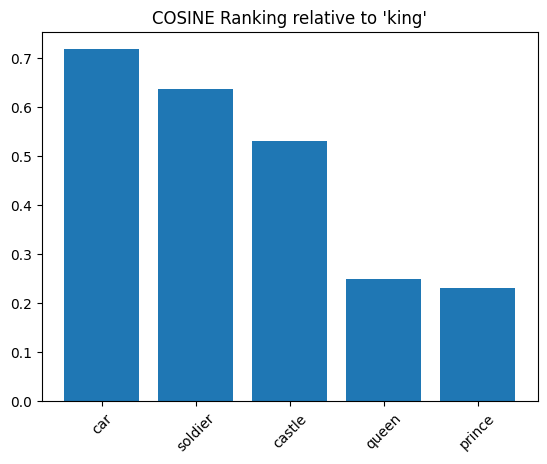

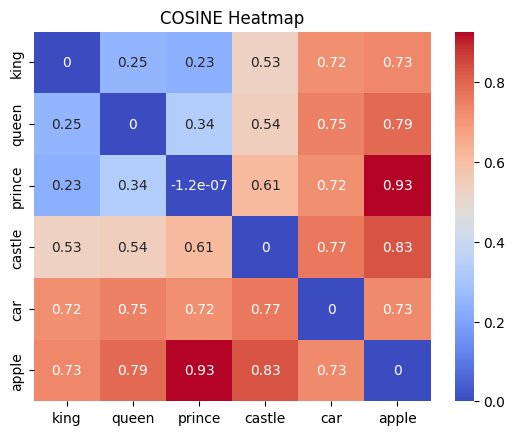

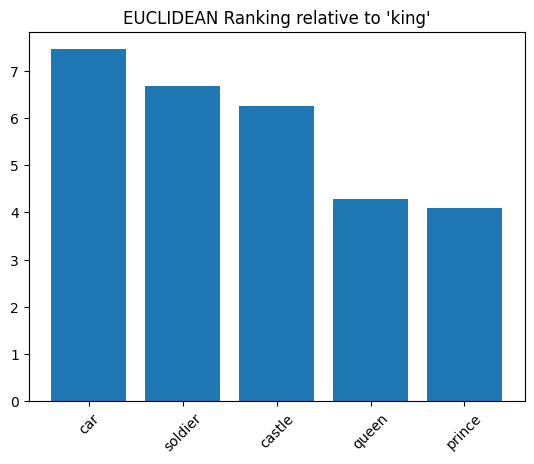

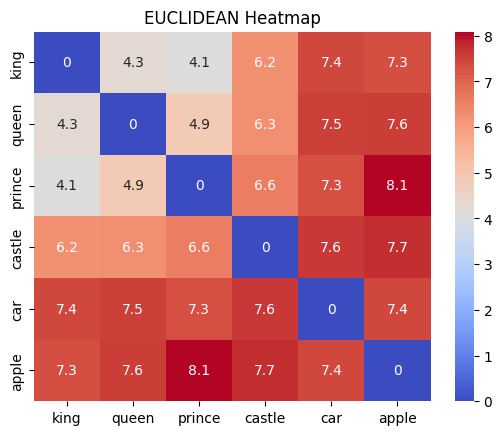

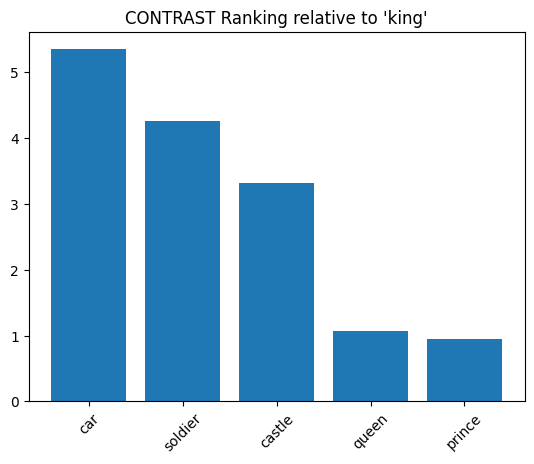

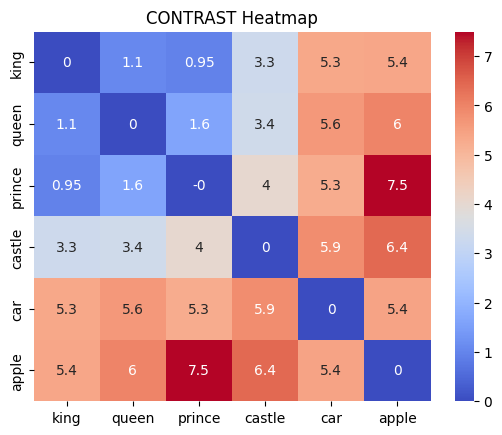

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

base = "king"
ranking_words = ["queen", "prince", "soldier", "castle", "car"]
heatmap_words = ["king", "queen", "prince", "castle", "car", "apple"]
metrics = ["cosine", "euclidean", "contrast"]

for metric in metrics:
    # ranking words
    ranking = compare_words(base, ranking_words, metric)
    labels, values = zip(*ranking)

    plt.figure()
    plt.bar(labels, values)
    plt.title(f"{metric.upper()} Ranking relative to '{base}'")
    plt.xticks(rotation=45)
    plt.show()

    # heatmap correlation
    matrix = []
    for w1 in heatmap_words:
        row = []
        for w2 in heatmap_words:
            v1, v2 = get_embedding(w1), get_embedding(w2)
            row.append(compute_metric(v1, v2, metric=metric))
        matrix.append(row)

    df = pd.DataFrame(matrix, index=heatmap_words, columns=heatmap_words)

    plt.figure()
    sns.heatmap(df, annot=True, cmap="coolwarm")
    plt.title(f"{metric.upper()} Heatmap")
    plt.show()

# Remember: LOWER dissimilarity scores means closer matched words
  # opposite of similarity

As one can see, the custom metric for dissimilarity is a strong option, combining the different angular/magnitude measures from cosine and euclidean. When looking at the word 'king', we can see that the custom metric scores 'queen' and 'prince' very close to 'king' by a much closer gap than the other measures. When we look at the various heatmaps, we see that the custom metric gives much more balanced pairwise scores (at least on these sampled words) compared to the other metrics. One outlier is the 'prince'/'apple' pair which all metrics score as highly dissimilar.